# Чат-бот со схемой профиля

## Итоги предыдущего раздела

Мы представили [LangGraph Memory Store](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore) как способ сохранения и извлечения долговременных воспоминаний.

Мы создали простой чат-бот, который использует как `кратковременную (внутри потока)`, так и `долговременную (между потоками)` память.

Он сохранял долговременную [семантическую память](https://docs.langchain.com/oss/python/concepts/memory#semantic-memory) (факты о пользователе) ["в горячем пути"](https://docs.langchain.com/oss/python/concepts/memory#writing-memories), пока пользователь общался с ним.

## Цели текущего раздела

Наш чат-бот сохранял воспоминания в виде строки. На практике мы часто хотим, чтобы воспоминания имели структуру.

Например, воспоминания могут быть [единой, постоянно обновляемой схемой](https://docs.langchain.com/oss/python/concepts/memory#profile).

В нашем случае мы хотим, чтобы это был единый профиль пользователя.

Мы расширим наш чат-бот для сохранения семантических воспоминаний в единый [профиль пользователя](https://docs.langchain.com/oss/python/concepts/memory#profile).

Мы также представим библиотеку [Trustcall](https://github.com/hinthornw/trustcall) для обновления этой схемы новой информацией.

In [41]:
%%capture --no-stderr
%pip install -U langchain_ollama langgraph trustcall langchain_core

In [42]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
os.environ["LANGSMITH_ENDPOINT"] = "https://eu.api.smith.langchain.com"

## Определение схемы профиля пользователя

Python имеет множество различных типов для [структурированных данных](https://docs.langchain.com/oss/python/langchain/models#structured-outputs), таких как TypedDict, словари, JSON и [Pydantic](https://docs.pydantic.dev/latest/).

Давайте начнем с использования TypedDict для определения схемы профиля пользователя.

In [43]:
from typing import TypedDict, List

class UserProfile(TypedDict):
    """User profile schema with typed fields"""
    user_name: str  # The user's preferred name
    interests: List[str]  # A list of the user's interests

## Сохранение схемы в хранилище

[LangGraph Store](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore) принимает любой словарь Python в качестве `value`.

In [44]:
# TypedDict instance
user_profile: UserProfile = {
    "user_name": "Lance",
    "interests": ["biking", "technology", "coffee"]
}
user_profile

{'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}

Мы используем метод [put](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore.put) для сохранения TypedDict в хранилище.

In [45]:
import uuid
from langgraph.store.memory import InMemoryStore

# Initialize the in-memory store
in_memory_store = InMemoryStore()

# Namespace for the memory to save
user_id = "1"
namespace_for_memory = (user_id, "memory")

# Save a memory to namespace as key and value
key = "user_profile"
value = user_profile
in_memory_store.put(namespace_for_memory, key, value)

Мы используем [search](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore.search) для извлечения объектов из хранилища по пространству имен.

In [46]:
# Search 
for m in in_memory_store.search(namespace_for_memory):
    print(m.dict())

{'namespace': ['1', 'memory'], 'key': 'user_profile', 'value': {'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}, 'created_at': '2025-11-07T08:19:33.505371+00:00', 'updated_at': '2025-11-07T08:19:33.505373+00:00', 'score': None}


Мы также можем использовать [get](https://reference.langchain.com/python/langgraph/store/?h=basestor#langgraph.store.base.BaseStore.get) для извлечения конкретного объекта по пространству имен и ключу.

In [47]:
# Get the memory by namespace and key
profile = in_memory_store.get(namespace_for_memory, "user_profile")
profile.value

{'user_name': 'Lance', 'interests': ['biking', 'technology', 'coffee']}

## Чат-бот со схемой профиля

Теперь мы знаем, как определить схему для воспоминаний и сохранить её в хранилище.

Теперь вопрос: как фактически *создавать* воспоминания с этой конкретной схемой?

В нашем чат-боте мы [хотим создавать воспоминания из пользовательского чата](https://docs.langchain.com/oss/python/concepts/memory#profile).

Здесь полезной оказывается концепция [структурированных выводов](https://docs.langchain.com/oss/python/langchain/models#structured-outputs).

Интерфейс [чат-модели](https://docs.langchain.com/oss/python/langchain/models) LangChain имеет метод [`with_structured_output`](https://docs.langchain.com/oss/python/langchain/models#structured-outputs) для обеспечения структурированного вывода.

Это полезно, когда мы хотим гарантировать, что вывод соответствует схеме, и метод автоматически парсит вывод для нас.

In [8]:
# _set_env("OPENAI_API_KEY")

Давайте передадим схему `UserProfile`, которую мы создали, в метод `with_structured_output`.

Затем мы можем вызвать чат-модель со списком [сообщений](https://docs.langchain.com/oss/python/langchain/messages) и получить структурированный вывод, соответствующий нашей схеме.

In [49]:
from pydantic import BaseModel, Field

from langchain_core.messages import HumanMessage
# from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama

# Initialize the model
model = ChatOllama(model="llama3.2:3b", temperature=0)

# Bind schema to model
model_with_structure = model.with_structured_output(UserProfile)

# Invoke the model to produce structured output that matches the schema
structured_output = model_with_structure.invoke([HumanMessage("My name is Lance, I like to bike.")])
structured_output

{'user_name': 'Lance', 'interests': ['biking']}

Теперь давайте используем это в нашем чат-боте.

Это требует лишь незначительных изменений в функции `write_memory`.

Мы используем `model_with_structure`, как определено выше, для создания профиля, соответствующего нашей схеме.

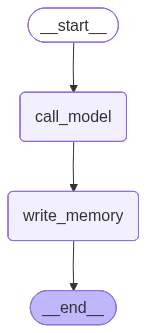

In [50]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_INSTRUCTION = """Create or update a user profile memory based on the user's chat history. 
This will be saved for long-term memory. If there is an existing memory, simply update it. 
Here is the existing memory (it may be empty): {memory}"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"
        )
    else:
        formatted_memory = None
        
    # Format the existing memory in the instruction
    system_msg = CREATE_MEMORY_INSTRUCTION.format(memory=formatted_memory)

    # Invoke the model to produce structured output that matches the schema
    new_memory = model_with_structure.invoke([SystemMessage(content=system_msg)]+state['messages'])

    # Overwrite the existing use profile memory
    key = "user_memory"
    store.put(namespace, key, new_memory)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [51]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "2"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance and I like to bike around San Francisco and eat at bakeries.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance and I like to bike around San Francisco and eat at bakeries.
================================== Ai Message ==================================

Nice to meet you, Lance! It sounds like you enjoy exploring the city on two wheels and indulging in some delicious baked goods. San Francisco has a lot of great bike routes and scenic spots to discover.

Are there any specific neighborhoods or bakeries that you particularly enjoy visiting? Do you have a favorite type of pastry or treat that you always look for when you're out biking?


Давайте проверим память в хранилище.

Мы видим, что память представляет собой словарь, соответствующий нашей схеме.

In [52]:
# Namespace for the memory to save
user_id = "2"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.value

{'user_name': 'Lance', 'interests': ['biking', 'San Francisco', 'bakeries']}

## Когда это может не сработать?

[`with_structured_output`](https://docs.langchain.com/oss/python/langchain/models#structured-outputs) очень полезен, но что произойдет, если мы работаем с более сложной схемой?

[Вот](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema) пример более сложной схемы, который мы протестируем ниже.

Это [Pydantic](https://docs.pydantic.dev/latest/) модель, описывающая предпочтения пользователя в общении и доверии.

In [53]:
from typing import List, Optional

class OutputFormat(BaseModel):
    preference: str
    sentence_preference_revealed: str

class TelegramPreferences(BaseModel):
    preferred_encoding: Optional[List[OutputFormat]] = None
    favorite_telegram_operators: Optional[List[OutputFormat]] = None
    preferred_telegram_paper: Optional[List[OutputFormat]] = None

class MorseCode(BaseModel):
    preferred_key_type: Optional[List[OutputFormat]] = None
    favorite_morse_abbreviations: Optional[List[OutputFormat]] = None

class Semaphore(BaseModel):
    preferred_flag_color: Optional[List[OutputFormat]] = None
    semaphore_skill_level: Optional[List[OutputFormat]] = None

class TrustFallPreferences(BaseModel):
    preferred_fall_height: Optional[List[OutputFormat]] = None
    trust_level: Optional[List[OutputFormat]] = None
    preferred_catching_technique: Optional[List[OutputFormat]] = None

class CommunicationPreferences(BaseModel):
    telegram: TelegramPreferences
    morse_code: MorseCode
    semaphore: Semaphore

class UserPreferences(BaseModel):
    communication_preferences: CommunicationPreferences
    trust_fall_preferences: TrustFallPreferences

class TelegramAndTrustFallPreferences(BaseModel):
    pertinent_user_preferences: UserPreferences

Теперь давайте попробуем извлечь эту схему с помощью метода `with_structured_output`.

In [54]:
from pydantic import ValidationError

# Bind schema to model
model_with_structure = model.with_structured_output(TelegramAndTrustFallPreferences)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

# Invoke the model
try:
    model_with_structure.invoke(f"""Extract the preferences from the following conversation:
    <convo>
    {conversation}
    </convo>""")
except ValidationError as e:
    print(e)

Если мы наивно пытаемся извлечь более сложные схемы, даже используя мощные модели вроде `gpt-4o`, это часто приводит к ошибкам.


## Trustcall для создания и обновления схем профилей

Как мы видим, работа со схемами может быть сложной.

Сложные схемы может быть трудно извлечь.

Кроме того, обновление даже простых схем может представлять трудности.

Рассмотрим наш вышеупомянутый чат-бот.

Мы перегенерировали схему профиля *с нуля* каждый раз, когда решали сохранить новое воспоминание.

Это неэффективно, потенциально тратя токены модели, если схема содержит много информации для повторной генерации каждый раз.

Что еще хуже, мы можем потерять информацию при перегенерации профиля с нуля.

Решение этих проблем является мотивацией для [TrustCall](https://github.com/hinthornw/trustcall)!

Это библиотека с открытым исходным кодом для обновления JSON-схем, разработанная [Уиллом Фу-Хинторном](https://github.com/hinthornw) из команды LangChain.

Она мотивирована именно этими проблемами при работе с памятью.

Давайте сначала покажем простое использование извлечения с TrustCall на этом списке [сообщений](https://docs.langchain.com/oss/python/langchain/messages).


In [55]:
# Conversation
conversation = [HumanMessage(content="Hi, I'm Lance."), 
                AIMessage(content="Nice to meet you, Lance."), 
                HumanMessage(content="I really like biking around San Francisco.")]

Мы используем `create_extractor`, передавая модель, а также нашу схему в качестве [инструмента](https://docs.langchain.com/oss/python/langchain/tools).

С TrustCall мы можем предоставлять схему различными способами.

Например, мы можем передать JSON-объект/словарь Python или Pydantic-модель.

Под капотом TrustCall использует [вызов инструментов](https://docs.langchain.com/oss/python/langchain/models#tool-calling) для создания [структурированного вывода](https://docs.langchain.com/oss/python/langchain/models#structured-outputs) из входного списка [сообщений](https://docs.langchain.com/oss/python/langchain/messages).

Чтобы заставить TrustCall производить структурированный вывод, мы можем включить имя схемы в аргумент `tool_choice`.

Мы можем вызвать экстрактор с приведенным выше диалогом.

In [57]:
from trustcall import create_extractor

# Schema 
class UserProfile(BaseModel):
    """User profile schema with typed fields"""
    user_name: str = Field(description="The user's preferred name")
    interests: List[str] = Field(description="A list of the user's interests")

# Initialize the model
model = ChatOllama(model="llama3.2:3b", temperature=0)

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile"
)

# Instruction
system_msg = "Extract the user profile from the following conversation"

# Invoke the extractor
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+conversation})

Когда мы вызываем экстрактор, мы получаем несколько вещей:

* `messages`: Список `AIMessages`, содержащих вызовы инструментов.
* `responses`: Результирующие распарсенные вызовы инструментов, соответствующие нашей схеме.
* `response_metadata`: Применимо при обновлении существующих вызовов инструментов. Показывает, какие из ответов соответствуют каким существующим объектам.


In [58]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (15503f80-a9a5-4727-b2cc-737bcc5e47f0)
 Call ID: 15503f80-a9a5-4727-b2cc-737bcc5e47f0
  Args:
    interests: ['biking']
    user_name: Lance


In [59]:
schema = result["responses"]
schema

[UserProfile(user_name='Lance', interests=['biking'])]

In [60]:
schema[0].model_dump()

{'user_name': 'Lance', 'interests': ['biking']}

In [61]:
result["response_metadata"]

[{'id': '15503f80-a9a5-4727-b2cc-737bcc5e47f0'}]

Давайте посмотрим, как мы можем использовать это для *обновления* профиля.

Для обновления TrustCall принимает набор сообщений, а также существующую схему.

Основная идея заключается в том, что он предлагает модели создать [JSON Patch](https://jsonpatch.com/) для обновления только соответствующих частей схемы.

Это менее подвержено ошибкам, чем наивная перезапись всей схемы.

Это также более эффективно, поскольку модели нужно генерировать только те части схемы, которые изменились.

Мы можем сохранить существующую схему как словарь.

Мы можем использовать `model_dump()` для сериализации экземпляра Pydantic-модели в словарь.

Мы передаем его в аргумент `"existing"` вместе с именем схемы `UserProfile`.

In [62]:
# Update the conversation
updated_conversation = [HumanMessage(content="Hi, I'm Lance."), 
                        AIMessage(content="Nice to meet you, Lance."), 
                        HumanMessage(content="I really like biking around San Francisco."),
                        AIMessage(content="San Francisco is a great city! Where do you go after biking?"),
                        HumanMessage(content="I really like to go to a bakery after biking."),]

# Update the instruction
system_msg = f"""Update the memory (JSON doc) to incorporate new information from the following conversation"""

# Invoke the extractor with the updated instruction and existing profile with the corresponding tool name (UserProfile)
result = trustcall_extractor.invoke({"messages": [SystemMessage(content=system_msg)]+updated_conversation}, 
                                    {"existing": {"UserProfile": schema[0].model_dump()}})  

In [63]:
for m in result["messages"]: 
    m.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  UserProfile (47ab8669-fbac-4e73-97a2-2666b759380b)
 Call ID: 47ab8669-fbac-4e73-97a2-2666b759380b
  Args:
    interests: ['bakery']
    user_name: bakeries


In [64]:
result["response_metadata"]

[{'id': '47ab8669-fbac-4e73-97a2-2666b759380b'}]

In [65]:
updated_schema = result["responses"][0]
updated_schema.model_dump()

{'user_name': 'bakeries', 'interests': ['bakery']}

Трассировка LangSmith:

https://smith.langchain.com/public/229eae22-1edb-44c6-93e6-489124a43968/r

Теперь давайте также протестируем Trustcall на [сложной схеме](https://github.com/hinthornw/trustcall?tab=readme-ov-file#complex-schema), которую мы видели ранее.

In [66]:
bound = create_extractor(
    model,
    tools=[TelegramAndTrustFallPreferences],
    tool_choice="TelegramAndTrustFallPreferences",
)

# Conversation
conversation = """Operator: How may I assist with your telegram, sir?
Customer: I need to send a message about our trust fall exercise.
Operator: Certainly. Morse code or standard encoding?
Customer: Morse, please. I love using a straight key.
Operator: Excellent. What's your message?
Customer: Tell him I'm ready for a higher fall, and I prefer the diamond formation for catching.
Operator: Done. Shall I use our "Daredevil" paper for this daring message?
Customer: Perfect! Send it by your fastest carrier pigeon.
Operator: It'll be there within the hour, sir."""

result = bound.invoke(
    f"""Extract the preferences from the following conversation:
<convo>
{conversation}
</convo>"""
)

# Extract the preferences
result["responses"][0]

AttributeError: 'ExtractionState' object has no attribute 'tool_call_id'

Трассировка:

https://smith.langchain.com/public/5cd23009-3e05-4b00-99f0-c66ee3edd06e/r

Для дополнительных примеров вы можете посмотреть обзорное видео [здесь](https://www.youtube.com/watch?v=-H4s0jQi-QY).

## Чат-бот с обновлением схемы профиля

Теперь давайте интегрируем Trustcall в наш чат-бот для создания *и обновления* профиля памяти.

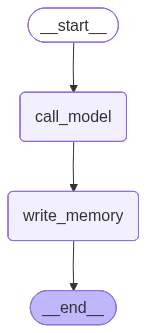

In [67]:
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.runnables.config import RunnableConfig
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.base import BaseStore

# Initialize the model
model = ChatOllama(model="llama3.2:3b", temperature=0)

# Schema 
class UserProfile(BaseModel):
    """ Profile of a user """
    user_name: str = Field(description="The user's preferred name")
    user_location: str = Field(description="The user's location")
    interests: list = Field(description="A list of the user's interests")

# Create the extractor
trustcall_extractor = create_extractor(
    model,
    tools=[UserProfile],
    tool_choice="UserProfile", # Enforces use of the UserProfile tool
)

# Chatbot instruction
MODEL_SYSTEM_MESSAGE = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Extraction instruction
TRUSTCALL_INSTRUCTION = """Create or update the memory (JSON doc) to incorporate information from the following conversation:"""

def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memory from the store and use it to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")

    # Format the memories for the system prompt
    if existing_memory and existing_memory.value:
        memory_dict = existing_memory.value
        formatted_memory = (
            f"Name: {memory_dict.get('user_name', 'Unknown')}\n"
            f"Location: {memory_dict.get('user_location', 'Unknown')}\n"
            f"Interests: {', '.join(memory_dict.get('interests', []))}"      
        )
    else:
        formatted_memory = None

    # Format the memory in the system prompt
    system_msg = MODEL_SYSTEM_MESSAGE.format(memory=formatted_memory)

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": response}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and save a memory to the store."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve existing memory from the store
    namespace = ("memory", user_id)
    existing_memory = store.get(namespace, "user_memory")
        
    # Get the profile as the value from the list, and convert it to a JSON doc
    existing_profile = {"UserProfile": existing_memory.value} if existing_memory else None
    
    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": [SystemMessage(content=TRUSTCALL_INSTRUCTION)]+state["messages"], "existing": existing_profile})
    
    # Get the updated profile as a JSON object
    updated_profile = result["responses"][0].model_dump()

    # Save the updated profile
    key = "user_memory"
    store.put(namespace, key, updated_profile)

# Define the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("write_memory", write_memory)
builder.add_edge(START, "call_model")
builder.add_edge("call_model", "write_memory")
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [68]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "1", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hello Lance! It's nice to meet you. I don't have any prior knowledge or memory of our previous interactions, so we're starting fresh. How can I assist you today?


IndexError: list index out of range

In [69]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

San Francisco is a great city for biking, with its scenic routes and mild climate. You must enjoy the views of the Golden Gate Bridge and the Presidio from your rides.

Are you a local or just visiting the area? Do you have a favorite route or spot that you like to explore on two wheels?


IndexError: list index out of range

In [ ]:
# Namespace for the memory to save
user_id = "1"
namespace = ("memory", user_id)
existing_memory = across_thread_memory.get(namespace, "user_memory")
existing_memory.dict()

In [70]:
# The user profile saved as a JSON object
existing_memory.value

{'user_name': 'Lance', 'interests': ['biking', 'San Francisco', 'bakeries']}

In [71]:
# User input 
input_messages = [HumanMessage(content="I also enjoy going to bakeries")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I also enjoy going to bakeries
================================== Ai Message ==================================

Bakeries are a great way to cap off a bike ride in San Francisco. You must love trying all the delicious pastries and treats at places like Boudin Bakery, Acme Bread Company, or Bi-Rite Bakery.

Do you have a favorite type of baked good that you always look for when you're out exploring the city? Are you more of a croissant or muffin person, or do you have a sweet tooth for something like sourdough bread or cookies?


IndexError: list index out of range

Продолжим разговор в новом потоке.

In [ ]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "2", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="What bakeries do you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

Трассировка:

https://smith.langchain.com

## Studio

![Screenshot 2024-10-30 at 11.26.31 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/6732d0437060f1754ea79908_Screenshot%202024-11-11%20at%207.48.53%E2%80%AFPM.png)